## Imports

In [93]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import os

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

## Helper functions

In [115]:
def clean_accuracy_data(path, accuracy_column_name):
    df = pd.read_csv(path)
    df.drop(columns=["Wall time"], inplace=True)
    df.rename(columns={"Step": "Batch number", "Value": accuracy_column_name}, inplace=True)
    df[accuracy_column_name] = (df[accuracy_column_name] * 100).round(2)
    df.set_index("Batch number", inplace=True)
    return df

def plot_accuracy_data(df, type="Train", ylim=(0, 100)):
    axis = df.plot(y=["Instantaneous", "Cumulative"], figsize=(10, 5))
    axis.set_title(f"{type} batch accuracy")
    axis.set_xlabel("Batch number")
    axis.set_ylabel("Accuracy")
    axis.set_ylim(*ylim)
    axis.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    axis.xaxis.set_major_formatter(mtick.EngFormatter())
    axis.grid()

def clean_loss_data(path, loss_column_name):
    df = pd.read_csv(path)
    df.drop(columns=["Wall time"], inplace=True)
    df.rename(columns={"Step": "Batch number", "Value": loss_column_name}, inplace=True)
    df.set_index("Batch number", inplace=True)
    return df

def plot_loss_data(df, type="Train", ylim=(0, 1)):
    axis = df.plot(y=["Instantaneous", "Cumulative"], figsize=(10, 5))
    axis.set_title(f"{type} mean square error loss")
    axis.set_xlabel("Batch number")
    axis.set_ylabel("Loss")
    axis.set_ylim(*ylim)
    axis.xaxis.set_major_formatter(mtick.EngFormatter())
    axis.grid()

# Adapted from https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot(label_to_embedding, perplexity):
    labels = []
    embedding = []

    for label in label_to_embedding:
        labels.append(label)
        embedding.append(label_to_embedding[label])
    
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=5000, random_state=23)
    new_embeddings = tsne_model.fit_transform(embeddings)

    x = []
    y = []
    for embedding in new_embeddings:
        x.append(embedding[0])
        y.append(embedding[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


def plot_attention_scores(model, moves, encoder_idx, head_idx):
    input_embedding = result_classifier.get_layer(index=0).input_embedding_layer
    positional_embedding = result_classifier.get_layer(index=0).positional_embedding_layer
    first_encoder_layer = result_classifier.get_layer(index=0).encoder_layers.layers[encoder_idx]
    attention_layer = first_encoder_layer.self_attention_layer.multihead_attention_layer
    
    x = input_embedding(moves)
    x = positional_embedding(x)
    queries = attention_layer.reshape_qkv(attention_layer.W_q(x))
    keys = attention_layer.reshape_qkv(attention_layer.W_k(x))
    
    d_k = tf.cast(512, tf.float32)
    scores = tf.linalg.matmul(queries, keys, transpose_b=True)
    scores /= tf.math.sqrt(d_k)
    weights = tf.nn.softmax(scores)

    head_weights = weights[0, head_idx, :, :].numpy()
    axis = sns.heatmap(head_weights)
    axis.set_title(f"Encoder {encoder_idx + 1}, Attention head {head_idx + 1}")
    plt.show()

# Credit: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0,.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.1%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.1f}%".format(accuracy * 100)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,
                annot=box_labels,
                fmt="",
                cmap=cmap,
                cbar=cbar,
                xticklabels=categories,
                yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## Validation dataset

In [3]:
PIECES = ["p", "n", "b", "r", "q", "k"]
RANK_NAMES = ["1", "2", "3", "4", "5", "6", "7", "8"]
FILE_NAMES = ["a", "b", "c", "d", "e", "f", "g", "h"]
SQUARES = [f + r for r in RANK_NAMES for f in FILE_NAMES]
PROMOTIONS = ["-", "=n", "=b", "=r", "=q"]
POSSIBLE_TOKENS = PIECES + SQUARES + PROMOTIONS

print("Number of tokens:", len(POSSIBLE_TOKENS))

Number of tokens: 75


In [4]:
POSSIBLE_RESULTS = ["0-1", "1-0", "1/2-1/2"]

FEATURE_DESCRIPTION = {
    "moves": tf.io.FixedLenFeature([], tf.string, default_value=''),
    "white_elo": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "black_elo": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "result": tf.io.FixedLenFeature([], tf.string, default_value=''),
}

MAX_GAME_LENGTH = 512

moves_vectorizer = tf.keras.layers.TextVectorization(
    output_mode="int",
    vocabulary=POSSIBLE_TOKENS,
    standardize=None,
    split="whitespace",
    output_sequence_length=MAX_GAME_LENGTH)

results_vectorizer = tf.keras.layers.StringLookup(
    vocabulary=POSSIBLE_RESULTS,
    num_oov_indices=1,
    output_mode="one_hot")

def prepare_example(example_proto):
    example = tf.io.parse_example(example_proto, FEATURE_DESCRIPTION)
    # [:,1:] is used to remove out-of-vocabulary index
    result_embedding = results_vectorizer(example["result"])[:,1:]
    tokenized_moves = moves_vectorizer(example["moves"])
    white_elo = tf.reshape(example["white_elo"], shape=(-1,1))
    black_elo = tf.reshape(example["black_elo"], shape=(-1,1))
    elos = tf.concat(values=[white_elo, black_elo], axis=1)
    return tokenized_moves, elos, result_embedding

validation_dataset_dir = "../data/dataset/validation_data/"
files = sorted([os.path.join(validation_dataset_dir, file) for file in os.listdir(validation_dataset_dir)])
dataset = tf.data.TFRecordDataset(filenames=files,
                                  num_parallel_reads=5,
                                  compression_type="GZIP")
dataset = dataset.batch(1).map(prepare_example)

## Result classifier

In [77]:
result_classifier = tf.keras.models.load_model("../model_artifacts/result_classifier/trained_model/saved_model/chessformer_result_classifier.keras")
result_classifier.summary()

Model: "chessformer_result_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_6 (Encoder)         multiple                  7395840   
                                                                 
 result_classification_1 (R  multiple                  37187     
 esultClassification)                                            
                                                                 
Total params: 7433027 (28.35 MB)
Trainable params: 7433027 (28.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


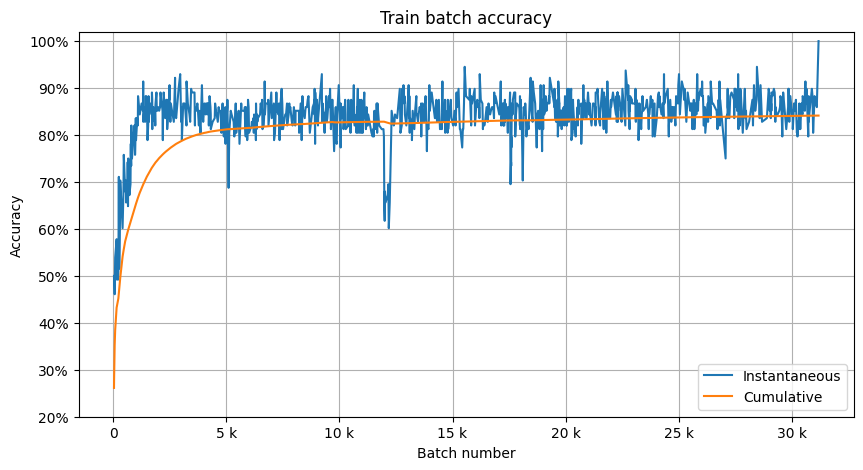

In [16]:
train_inst_acc = clean_accuracy_data(
    "../model_artifacts/result_classifier/training_metrics/train/instantaneous_batch_accuracy_epoch1.csv",
    "Instantaneous"
)
train_cum_acc = clean_accuracy_data(
    "../model_artifacts/result_classifier/training_metrics/train/cumulative_batch_accuracy_epoch1.csv",
    "Cumulative"
)

train_acc = train_inst_acc.join(train_cum_acc)

plot_accuracy_data(train_acc, type="Train", ylim=(20,102))

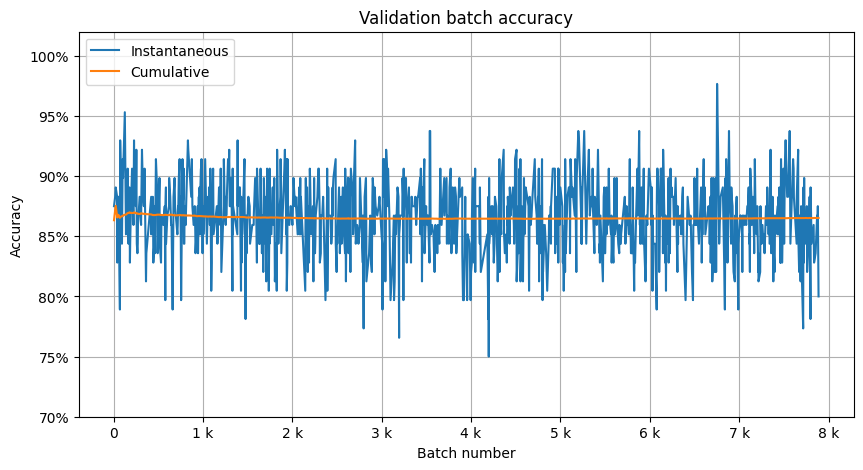

In [17]:
val_inst_acc = clean_accuracy_data(
    "../model_artifacts/result_classifier/training_metrics/validation/instantaneous_batch_accuracy_epoch1.csv",
    "Instantaneous"
)
val_cum_acc = clean_accuracy_data(
    "../model_artifacts/result_classifier/training_metrics/validation/cumulative_batch_accuracy_epoch1.csv",
    "Cumulative"
)

val_acc = val_inst_acc.join(val_cum_acc)

plot_accuracy_data(val_acc, type="Validation", ylim=(70, 102))

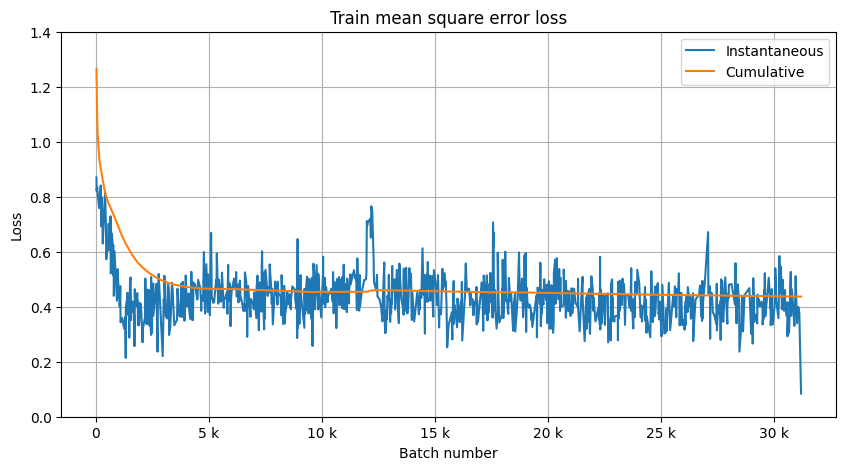

In [38]:
train_inst_loss = clean_loss_data(
    "../model_artifacts/result_classifier/training_metrics/train/instantaneous_batch_loss_epoch1.csv",
    "Instantaneous"
)
train_cum_loss = clean_loss_data(
    "../model_artifacts/result_classifier/training_metrics/train/cumulative_batch_loss_epoch1.csv",
    "Cumulative"
)

train_loss = train_inst_loss.join(train_cum_loss)

plot_loss_data(train_loss, type="Train", ylim=(0, 1.4))

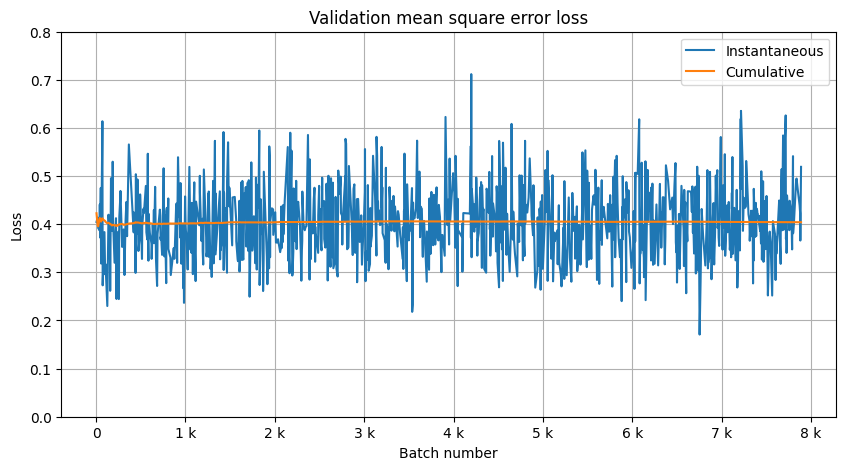

In [39]:
val_inst_loss = clean_loss_data(
    "../model_artifacts/result_classifier/training_metrics/validation/instantaneous_batch_loss_epoch1.csv",
    "Instantaneous"
)
val_cum_loss = clean_loss_data(
    "../model_artifacts/result_classifier/training_metrics/validation/cumulative_batch_loss_epoch1.csv",
    "Cumulative"
)

val_loss = val_inst_loss.join(val_cum_loss)

plot_loss_data(val_loss, type="Validation", ylim=(0, 0.8))

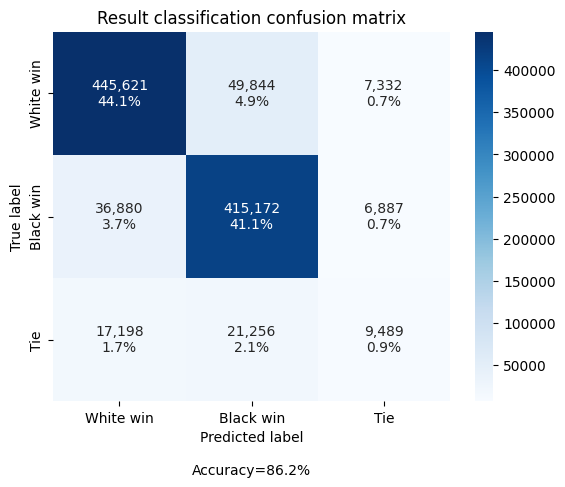

In [116]:
raw_predictions = pd.read_csv("../model_artifacts/result_classifier/training_metrics/validation/raw_predictions.csv")
categories = ["White win", "Black win", "Tie"] # Order is important
cm = confusion_matrix(y_true=raw_predictions["True results"], y_pred=raw_predictions["Predicted results"], labels=categories)
make_confusion_matrix(cm, categories=categories, title="Result classification confusion matrix")

In [9]:
encoder = result_classifier.get_layer(index=0)
embeddings = encoder.input_embedding_layer.get_weights()[0]
print("Original embedding matric shape:", embeddings.shape)
# The first and second embeddings correspond to the empty string and UNK, respectively
# Excluding them here
embeddings = embeddings[2:]
print("Excluding non-chess tokens:", embeddings.shape)

Original embedding matric shape: (77, 512)
Excluding non-chess tokens: (75, 512)


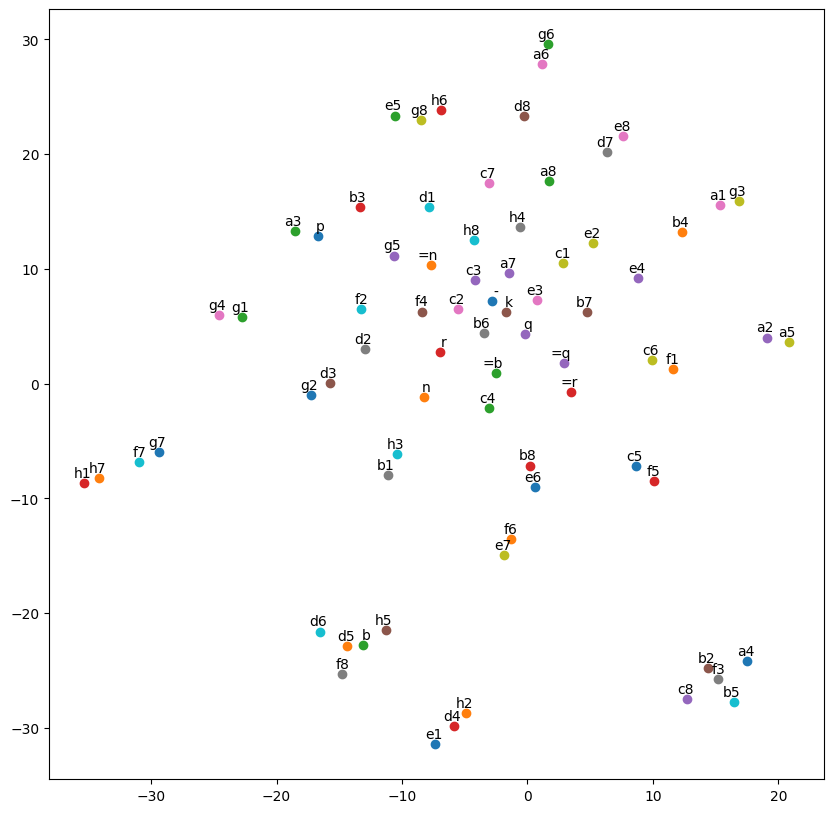

In [22]:
label_to_embedding = {label: embedding for label, embedding in zip(POSSIBLE_TOKENS, embeddings)}

tsne_plot(label_to_embedding, 2)

In [81]:
it = iter(dataset)
moves, elos, result = next(it)

predicted_result = result_classifier.predict(moves)
print("Result:", result)
print("Predicted result:", predicted_result)

1/1 [==============================] - 0s 55ms/step
Result: tf.Tensor([[0. 1. 0.]], shape=(1, 3), dtype=float32)
Predicted result: [[0.01776288 0.9731631  0.00907398]]


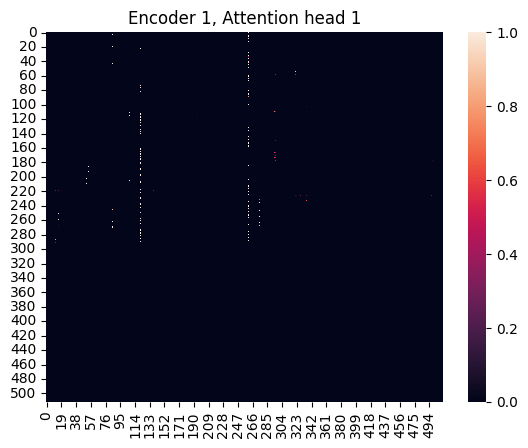

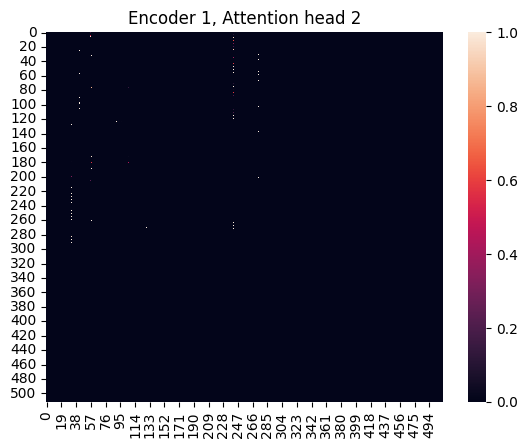

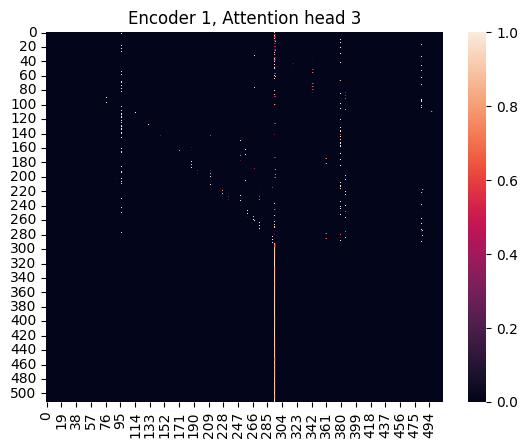

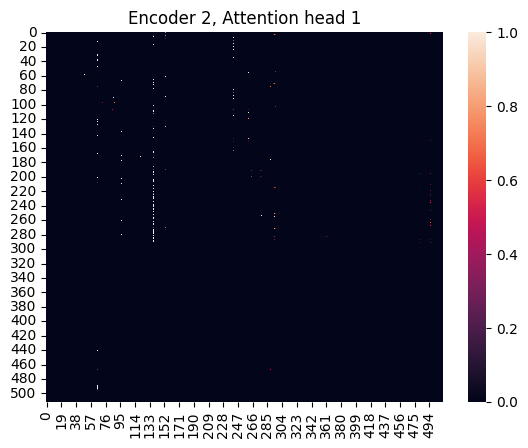

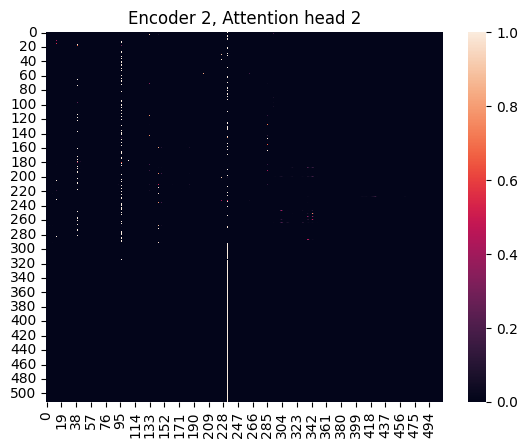

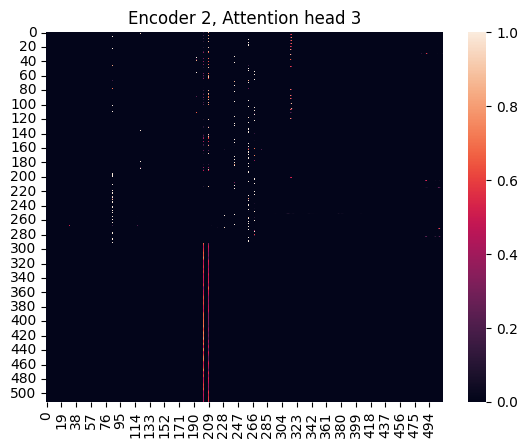

In [236]:
for encoder_idx in range(0, 2):
    for head_idx in range(0, 3):
        plot_attention_scores(result_classifier, moves, encoder_idx, head_idx)

## Elo Regressor

### From scratch

### Fine-tuned

In [65]:
elo_regressor_fine_tuned = tf.keras.models.load_model("../model_artifacts/elo_regressor/fine_tuned/trained_model/saved_model/chessformer_result_classifier.keras")
elo_regressor_fine_tuned.summary()

Model: "chessformer_elo_regressor_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  7395840   
                                                                 
 elo_regression_4 (EloRegre  multiple                  37378     
 ssion)                                                          
                                                                 
Total params: 7433218 (28.36 MB)
Trainable params: 7433218 (28.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


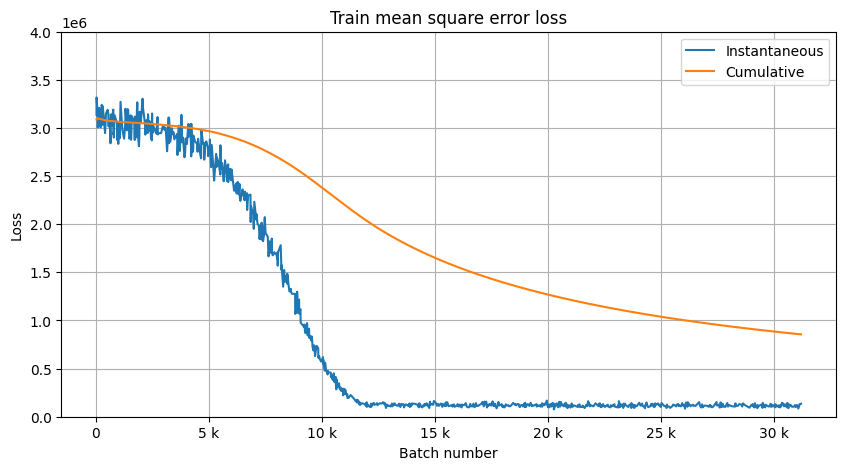

In [66]:
train_inst_loss = clean_loss_data(
    "../model_artifacts/elo_regressor/fine_tuned/training_metrics/train/instantaneous_batch_loss_epoch1.csv",
    "Instantaneous"
)
train_cum_loss = clean_loss_data(
    "../model_artifacts/elo_regressor/fine_tuned/training_metrics/train/cumulative_batch_loss_epoch1.csv",
    "Cumulative"
)

train_loss = train_inst_loss.join(train_cum_loss)

plot_loss_data(train_loss, type="Train", ylim=(0, 4e6))

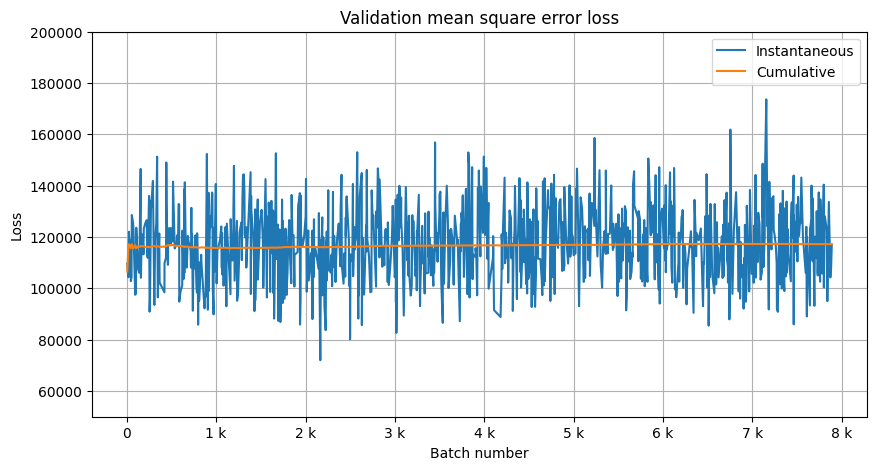

In [67]:
val_inst_loss = clean_loss_data(
    "../model_artifacts/elo_regressor/fine_tuned/training_metrics/validation/instantaneous_batch_loss_epoch1.csv",
    "Instantaneous"
)
val_cum_loss = clean_loss_data(
    "../model_artifacts/elo_regressor/fine_tuned/training_metrics/validation/cumulative_batch_loss_epoch1.csv",
    "Cumulative"
)

val_loss = val_inst_loss.join(val_cum_loss)

plot_loss_data(val_loss, type="Validation", ylim=(5e4, 2e5))

In [68]:
true_white_elos = list()
true_black_elos = list()
predicted_white_elos = list()
predicted_black_elos = list()

for i, (moves, elos, result) in enumerate(dataset.take(2_000)):
    true_white_elos.append(elos[0][0].numpy())
    true_black_elos.append(elos[0][1].numpy())
    predicted_elos = elo_regressor_fine_tuned.predict(moves, verbose=0)
    predicted_white_elos.append(predicted_elos[0][0])
    predicted_black_elos.append(predicted_elos[0][1])
    if i % 100 == 0:
        print(f"Processed {i + 1} examples")

Processed 1 examples
Processed 101 examples
Processed 201 examples
Processed 301 examples
Processed 401 examples
Processed 501 examples
Processed 601 examples
Processed 701 examples
Processed 801 examples
Processed 901 examples
Processed 1001 examples
Processed 1101 examples
Processed 1201 examples
Processed 1301 examples
Processed 1401 examples
Processed 1501 examples
Processed 1601 examples
Processed 1701 examples
Processed 1801 examples
Processed 1901 examples


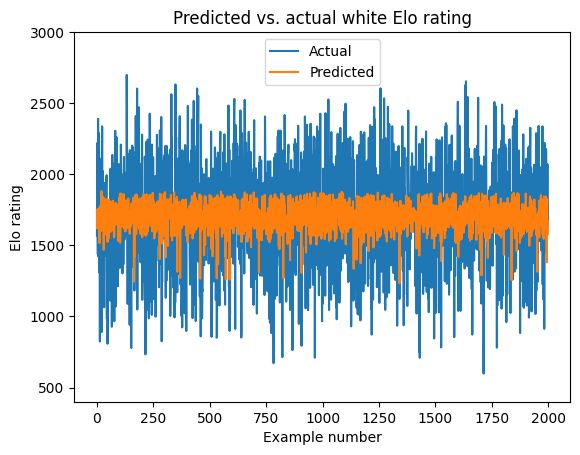

In [69]:
plt.plot(range(2_000), true_white_elos, label="Actual")
plt.ylim(400, 3000)

plt.plot(range(2_000), predicted_white_elos, label="Predicted")
plt.ylim(400, 3000)

plt.title("Predicted vs. actual white Elo rating")
plt.xlabel("Example number")
plt.ylabel("Elo rating")
plt.legend()
plt.show()

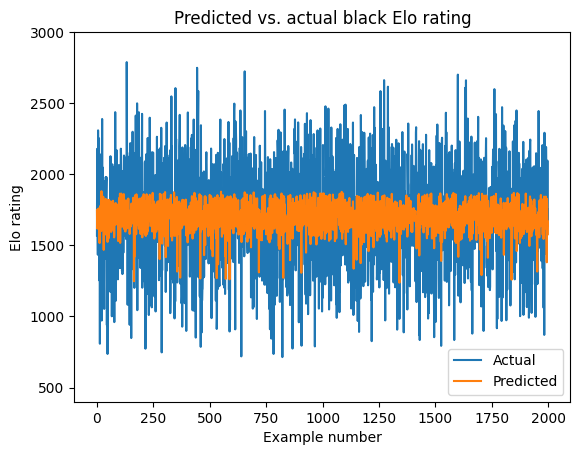

In [70]:
plt.plot(range(2_000), true_black_elos, label="Actual")
plt.ylim(400, 3000)

plt.plot(range(2_000), predicted_black_elos, label="Predicted")
plt.ylim(400, 3000)

plt.title("Predicted vs. actual black Elo rating")
plt.xlabel("Example number")
plt.ylabel("Elo rating")
plt.legend()
plt.show()

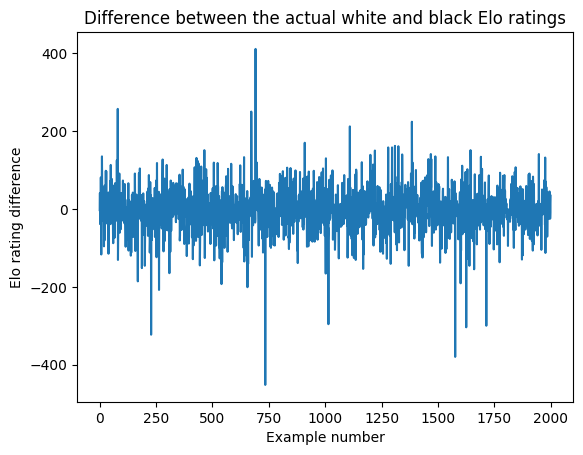

In [71]:
plt.plot(range(2_000), [white - black for white, black in zip(true_white_elos, true_black_elos)])
plt.title("Difference between the actual white and black Elo ratings")
plt.xlabel("Example number")
plt.ylabel("Elo rating difference")
plt.show()

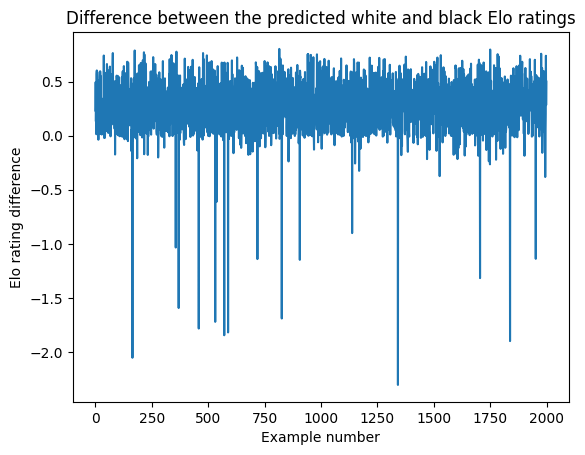

In [72]:
plt.plot(range(2_000), [white - black for white, black in zip(predicted_white_elos, predicted_black_elos)])
plt.title("Difference between the predicted white and black Elo ratings")
plt.xlabel("Example number")
plt.ylabel("Elo rating difference")
plt.show()

### Large

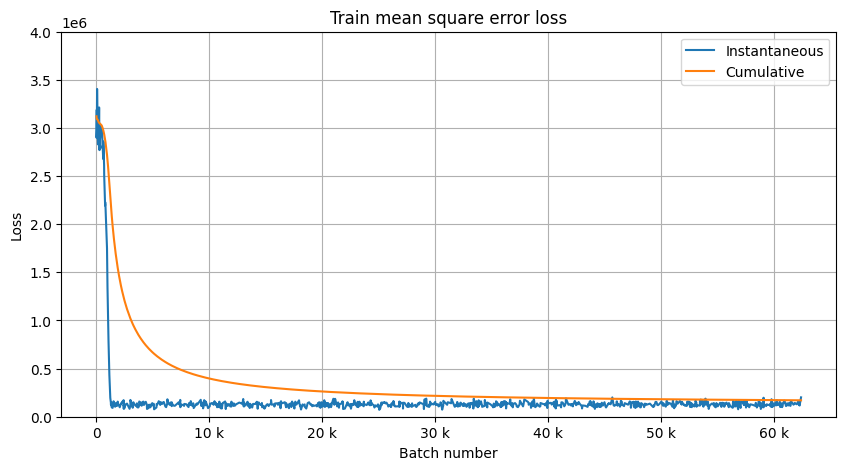

In [73]:
train_inst_loss = clean_loss_data(
    "../model_artifacts/elo_regressor/large/training_metrics/train/instantaneous_batch_loss_epoch1.csv",
    "Instantaneous"
)
train_cum_loss = clean_loss_data(
    "../model_artifacts/elo_regressor/large/training_metrics/train/cumulative_batch_loss_epoch1.csv",
    "Cumulative"
)

train_loss = train_inst_loss.join(train_cum_loss)

plot_loss_data(train_loss, type="Train", ylim=(0, 4e6))

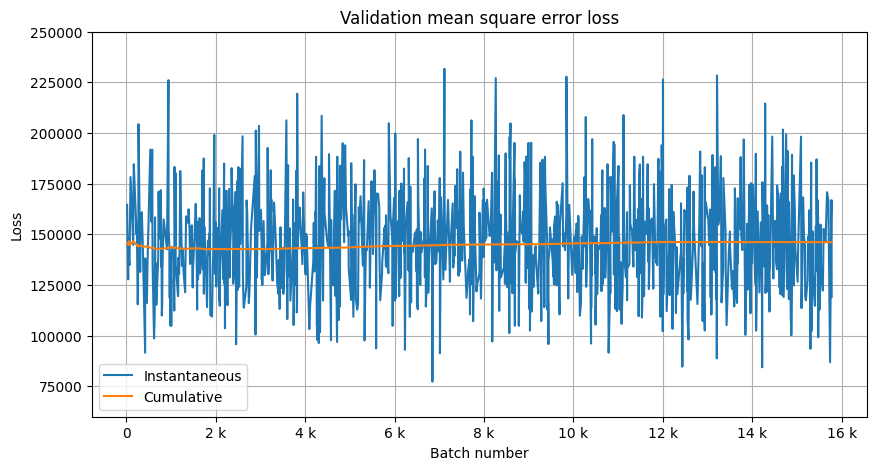

In [76]:
val_inst_loss = clean_loss_data(
    "../model_artifacts/elo_regressor/large/training_metrics/validation/instantaneous_batch_loss_epoch1.csv",
    "Instantaneous"
)
val_cum_loss = clean_loss_data(
    "../model_artifacts/elo_regressor/large/training_metrics/validation/cumulative_batch_loss_epoch1.csv",
    "Cumulative"
)

val_loss = val_inst_loss.join(val_cum_loss)

plot_loss_data(val_loss, type="Validation", ylim=(6e4, 2.5e5))